In [4]:
!pip install DeepPurpose


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
print("Torch version: ", torch.__version__)
print("Cuda available:", torch.cuda.is_available())

from torch_geometric.data import Data
print("Pytorch Geometric imported OK")

from rdkit import Chem
print("RDkit imported OK")

from DeepPurpose import utils, dataset
print("DeepPurpose imported OK")

Torch version:  2.2.1
Cuda available: False
Pytorch Geometric imported OK
RDkit imported OK
DeepPurpose imported OK


In [3]:
X_drugs, X_targets, y = dataset.load_process_DAVIS(path='./data', binary=True)

Beginning Processing...
100% [....................................] 179878 / 179878Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!


In [4]:
print("Number of samples ", len(X_drugs))
print("Example drug SMILES:", X_drugs[0][:60], "...")
print("Example target sequence (first 60 aa)", X_targets[0][:60], "...")
print("Example label:", y[0])

Number of samples  30056
Example drug SMILES: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N ...
Example target sequence (first 60 aa) MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIV ...
Example label: 0


SMILES -> Graph

In [6]:
def smiles_to_graph(smiles: str) -> Data:
    """Convert a SMILES string into a PyTorch Geometric Data object."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Could not parse SMILES: {smiles}")
    
    # Node features: atomic numbers as a single feature
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])  # shape [num_atoms, 1]

    # Edges: bonds, made undirected by adding (i,j) and (j,i)
    edges = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # [2, num_edges]

    data = Data(x=x, edge_index=edge_index)
    return data

# Test on one real drug from DAVIS
test_smiles = X_drugs[0]
graph = smiles_to_graph(test_smiles)

print(graph)
print("Node feature shape:", graph.x.shape)
print("Edge index shape:", graph.edge_index.shape)

Data(x=[27, 1], edge_index=[2, 60])
Node feature shape: torch.Size([27, 1])
Edge index shape: torch.Size([2, 60])


In [7]:
from torch.utils.data import Dataset as TorchDataset

# 20 standard amino acids
AA_VOCAB = "ACDEFGHIKLMNPQRSTVWY"

def seq_to_freq_vector(seq: str) -> torch.Tensor:
    """Convert an amino-acid sequence into a 20-dim frequency vector."""
    seq = seq.upper()
    counts = []
    for aa in AA_VOCAB:
        counts.append(seq.count(aa))
    counts = torch.tensor(counts, dtype=torch.float32)
    length = max(len(seq), 1)
    freq = counts / length  # normalize
    return freq  # shape [20]


In [8]:
class DTIDataset(TorchDataset):
    def __init__(self, smiles_list, target_list, labels):
        self.smiles_list = smiles_list
        self.target_list = target_list
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        target_seq = self.target_list[idx]
        label = self.labels[idx]

        drug_graph = smiles_to_graph(smiles)            # PyG Data object
        protein_feat = seq_to_freq_vector(target_seq)   # [20] tensor

        return drug_graph, protein_feat, label

dataset = DTIDataset(X_drugs, X_targets, y)
print("Dataset length:", len(dataset))

drug_graph0, protein_feat0, label0 = dataset[0]
print("First label:", label0.item())
print("Protein feature shape:", protein_feat0.shape)
print("Drug graph:", drug_graph0)


Dataset length: 30056
First label: 0.0
Protein feature shape: torch.Size([20])
Drug graph: Data(x=[27, 1], edge_index=[2, 60])


In [9]:
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def collate_fn(batch):
    """
    batch is a list of tuples:
        (drug_graph, protein_feat, label)
    for each sample in the batch.
    """
    # Unzip the list of tuples into three lists
    drug_graphs, protein_feats, labels = zip(*batch)
    
    # 1) Batch the list of PyG Data objects into a single Batch object
    batched_graphs = Batch.from_data_list(drug_graphs)
    
    # 2) Stack protein feature tensors into a [batch_size, 20] tensor
    protein_feats = torch.stack(protein_feats, dim=0)
    
    # 3) Stack labels into a [batch_size] tensor
    labels = torch.stack(labels, dim=0)
    
    return batched_graphs, protein_feats, labels


In [10]:
# Use the full dataset you created earlier
full_dataset = dataset  # DTIDataset(X_drugs, X_targets, y)

# 80/20 train/validation split using indices
indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

# Create DataLoaders
train_loader = PyGDataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = PyGDataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))


Train batches: 376
Validation batches: 94


In [11]:
# Inspect one batch
batch_drug_graphs, batch_protein_feats, batch_labels = next(iter(train_loader))

print(batch_drug_graphs)
print("Batched node features shape:", batch_drug_graphs.x.shape)
print("Batched edge index shape:", batch_drug_graphs.edge_index.shape)
print("Batch vector shape:", batch_drug_graphs.batch.shape)
print("Protein batch shape:", batch_protein_feats.shape)
print("Labels batch shape:", batch_labels.shape)


DataBatch(x=[2040, 1], edge_index=[2, 4516], batch=[2040], ptr=[65])
Batched node features shape: torch.Size([2040, 1])
Batched edge index shape: torch.Size([2, 4516])
Batch vector shape: torch.Size([2040])
Protein batch shape: torch.Size([64, 20])
Labels batch shape: torch.Size([64])


In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class DrugGNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, out_dim=128):
        super().__init__()
        # First graph convolution: 1 → 64 features per atom
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Second graph convolution: 64 → 128 features per atom
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, data):
        """
        data is a PyG Batch object with:
          - data.x          : node features [N_total_nodes, input_dim]
          - data.edge_index : edges [2, E_total]
          - data.batch      : batch vector [N_total_nodes]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First message passing layer + nonlinearity
        x = F.relu(self.conv1(x, edge_index))
        # Second message passing layer + nonlinearity
        x = F.relu(self.conv2(x, edge_index))

        # Pool node features into one vector per graph (molecule)
        # global_mean_pool uses 'batch' to know which nodes belong together
        graph_emb = global_mean_pool(x, batch)  # [batch_size, out_dim]

        return graph_emb


In [13]:
class ProteinEncoder(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, out_dim=128):
        super().__init__()
        # First fully-connected layer: 20 → 64
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Second fully-connected layer: 64 → 128
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        """
        x: protein feature batch [batch_size, 20]
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x  # [batch_size, 128]


In [14]:
class DTIModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.drug_gnn = DrugGNN()          # encodes molecule graphs
        self.protein_enc = ProteinEncoder() # encodes protein features

        # Final classifier: 128 (drug) + 128 (protein) = 256 input features
        self.fc = nn.Sequential(
            nn.Linear(128 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # output is a single logit
        )

    def forward(self, drug_graphs, protein_feats):
        """
        drug_graphs: PyG Batch (batched molecular graphs)
        protein_feats: [batch_size, 20] tensor
        """
        # 1) Encode drugs with GNN → [batch_size, 128]
        d = self.drug_gnn(drug_graphs)

        # 2) Encode proteins → [batch_size, 128]
        p = self.protein_enc(protein_feats)

        # 3) Concatenate along feature dimension → [batch_size, 256]
        x = torch.cat([d, p], dim=1)

        # 4) Pass through final classifier → [batch_size, 1]
        logits = self.fc(x)

        # 5) Squeeze last dimension so shape is [batch_size]
        return logits.squeeze(-1)

In [15]:
model = DTIModel()

batch_drug_graphs, batch_protein_feats, batch_labels = next(iter(train_loader))

logits = model(batch_drug_graphs, batch_protein_feats)

print("Logits shape:", logits.shape)
print("Example logits:", logits[:5])
print("Matching labels:", batch_labels[:5])


Logits shape: torch.Size([64])
Example logits: tensor([-0.0047, -0.0059, -0.0046, -0.0052, -0.0040], grad_fn=<SliceBackward0>)
Matching labels: tensor([0., 0., 0., 0., 0.])


In [16]:
# Create a fresh model
model = DTIModel()

# Binary classification → use BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer: common default choice for deep learning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [19]:
import matplotlib.pyplot as plt

num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---- TRAINING ----
    model.train()
    total_loss = 0.0
    total_samples = 0

    for batch_drug_graphs, batch_protein_feats, batch_labels in train_loader:
        optimizer.zero_grad()
        logits = model(batch_drug_graphs, batch_protein_feats)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()

        batch_size = batch_labels.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_samples = 0

    with torch.no_grad():
        for batch_drug_graphs, batch_protein_feats, batch_labels in val_loader:
            logits = model(batch_drug_graphs, batch_protein_feats)
            loss = criterion(logits, batch_labels)

            batch_size = batch_labels.size(0)
            val_loss += loss.item() * batch_size
            val_samples += batch_size

    avg_val_loss = val_loss / val_samples
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- Train loss: {avg_train_loss:.4f} "
        f"- Val loss: {avg_val_loss:.4f}"
    )


Epoch 1/5 - Train loss: 0.1929 - Val loss: 0.1800
Epoch 2/5 - Train loss: 0.1933 - Val loss: 0.1765
Epoch 3/5 - Train loss: 0.1923 - Val loss: 0.1767
Epoch 4/5 - Train loss: 0.1917 - Val loss: 0.1753
Epoch 5/5 - Train loss: 0.1922 - Val loss: 0.1759


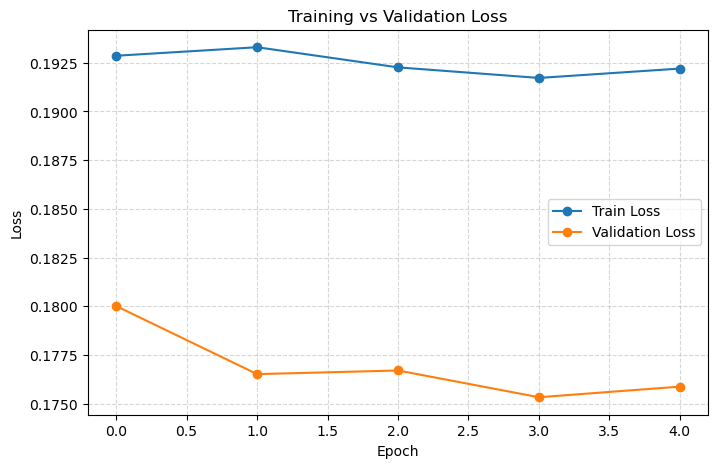

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
